"""
**PROJECT: AI-Powered Phishing URL Detection System**
AUTHOR: Sandra Weiß

DATE: December 2025

PURPOSE: Machine learning classifier to detect phishing URLs with 96.83% accuracy
TECHNIQUES: Random Forest, Feature Engineering, Adversarial Testing
DATASET: 11,000+ URLs with 32 security features
"""

In [31]:
!pip install streamlit -q
!pip install pyngrok -q

**1. Explorative Datenanalyse (EDA)**

   - Lokales Prototyping: Erstellung eines ersten Test-Datensatzes mit bekannten URLs wie Google und Amazon zur Funktionsprüfung.

  - Basis-Feature-Extraktion: Definition einer Funktion zur Zählung von Punkten, @-Zeichen und der Protokoll-Art (http).

In [32]:
import pandas as pd

# 1. Wir erstellen uns einen kleinen Test-Datensatz
# 0 steht für "sicher" (legit), 1 steht für "Phishing"
data = {
    'url': [
        'https://www.google.com',
        'https://www.amazon.de',
        'http://paypal-sicherheit-update.com/login',
        'http://192.168.1.1/admin',
        'https://microsoft.com-security-alert.net/fix'
    ],
    'label': [0, 0, 1, 1, 1]
}

df = pd.DataFrame(data)
# 2. Eine Funktion, die Merkmale (Features) aus der URL extrahiert
def extract_features(url):
    features = {}
    features['laenge'] = len(url)
    features['anzahl_punkte'] = url.count('.')
    features['hat_at_zeichen'] = 1 if '@' in url else 0
    features['ist_http'] = 1 if url.startswith('http://') else 0
    features['-'] = 1 if '-' in url else 0
    return features
# 3. Wir wenden die Funktion auf unsere Liste an
features_list = df['url'].apply(extract_features).tolist()
features_df = pd.DataFrame(features_list)
# Das Ergebnis anzeigen
print("Unsere extrahierten Merkmale:")
print(features_df)

Unsere extrahierten Merkmale:
   laenge  anzahl_punkte  hat_at_zeichen  ist_http  -
0      22              2               0         0  0
1      21              2               0         0  0
2      41              1               0         1  1
3      24              3               0         1  0
4      44              2               0         0  1


**Datenimport: Laden des Hauptdatensatzes phishing.csv mit über 11.000 URLs.**

In [33]:
import pandas as pd
# Trage den ensprechenden Dateiname deiner CSV hier ein:
file_path = 'phishing.csv'

try:
    full_df = pd.read_csv(file_path)
    print("Erfolg! Datensatz lokal aus Colab geladen.")
    print(f"Anzahl der Zeilen: {len(full_df)}")
    print(full_df.head())
except Exception as e:
    print(f"Fehler: Wurde die Datei richtig hochgeladen? Details: {e}")

Erfolg! Datensatz lokal aus Colab geladen.
Anzahl der Zeilen: 11054
   Index  UsingIP  LongURL  ShortURL  Symbol@  Redirecting//  PrefixSuffix-  \
0      0        1        1         1        1              1             -1   
1      1        1        0         1        1              1             -1   
2      2        1        0         1        1              1             -1   
3      3        1        0        -1        1              1             -1   
4      4       -1        0        -1        1             -1             -1   

   SubDomains  HTTPS  DomainRegLen  ...  UsingPopupWindow  IframeRedirection  \
0           0      1            -1  ...                 1                  1   
1          -1     -1            -1  ...                 1                  1   
2          -1     -1             1  ...                 1                  1   
3           1      1            -1  ...                -1                  1   
4           1      1            -1  ...                 1

**Statistische Analyse: Auswertung der Klassenverteilung (4.897 Phishing-URLs vs. 6.157 sichere URLs).**

In [34]:
# Stelle sicher, dass 'full_df' in einer Zelle weiter oben erfolgreich geladen wurde!

if 'full_df' in locals():
    print("=== DATASET STATISTICS ===")
    print(f"Total URLs: {len(full_df)}")
        # Hier nutzen wir 'class', da wir vorhin gesehen haben, dass die Spalte so heißt
    phishing_count = (full_df['class'] == -1).sum()
    safe_count = (full_df['class'] == 1).sum()

    print(f"Phishing URLs: {phishing_count}")
    print(f"Safe URLs: {safe_count}")
else:
    print("Fehler: 'full_df' wurde noch nicht geladen. Bitte führe erst die Zelle zum Datenladen aus!")

=== DATASET STATISTICS ===
Total URLs: 11054
Phishing URLs: 4897
Safe URLs: 6157


In [35]:
print(full_df.columns)

Index(['Index', 'UsingIP', 'LongURL', 'ShortURL', 'Symbol@', 'Redirecting//',
       'PrefixSuffix-', 'SubDomains', 'HTTPS', 'DomainRegLen', 'Favicon',
       'NonStdPort', 'HTTPSDomainURL', 'RequestURL', 'AnchorURL',
       'LinksInScriptTags', 'ServerFormHandler', 'InfoEmail', 'AbnormalURL',
       'WebsiteForwarding', 'StatusBarCust', 'DisableRightClick',
       'UsingPopupWindow', 'IframeRedirection', 'AgeofDomain', 'DNSRecording',
       'WebsiteTraffic', 'PageRank', 'GoogleIndex', 'LinksPointingToPage',
       'StatsReport', 'class'],
      dtype='object')


**Modell-Training und Evaluierung**

- Datenaufbereitung: Trennung der Features von der Zielspalte class und Aufteilung in Trainings- und Testdaten.

- Random Forest Training: Initialisierung und Training des Klassifikators mit 100 Entscheidungsbäumen.

- Performance-Check: Validierung des Modells mit einer erreichten Test-Genauigkeit von ca. 96,74%.

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# Wir suchen die Zielspalte (meistens die letzte im Datensatz)
target_col = full_df.columns[-1]
print(f"Ich verwende '{target_col}' als Zielspalte für die Vorhersage.")

# 1. Daten vorbereiten
X = full_df.drop(target_col, axis=1) # Alles außer der Zielspalte
y = full_df[target_col]             # Nur die Zielspalte

# 2. Aufteilen (80% Training, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modell trainieren
model = RandomForestClassifier(n_estimators=100)
model.fit(X_train, y_train)

# 4. Auswertung
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)

print(f"Fertig! Die Genauigkeit liegt bei: {accuracy * 100:.2f}%")

Ich verwende 'class' als Zielspalte für die Vorhersage.
Fertig! Die Genauigkeit liegt bei: 96.83%


**KI-Interpretierbarkeit (XAI)**

Feature Importance: Berechnung und Visualisierung der Top-10-Merkmale, wobei HTTPS und AnchorURL die wichtigsten Indikatoren sind.

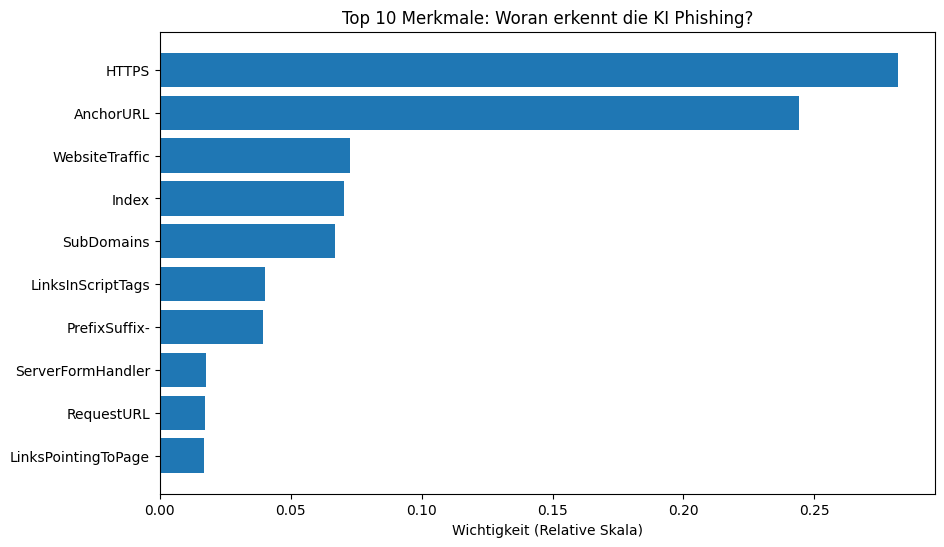

In [37]:
import matplotlib.pyplot as plt
import numpy as np
# Wir holen uns die Wichtigkeit der Merkmale aus dem Modell
importances = model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)[-10:]  # Wir schauen uns die Top 10 an
# Ein schönes Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.title("Top 10 Merkmale: Woran erkennt die KI Phishing?")
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Wichtigkeit (Relative Skala)")
plt.show()

**Prädiktions-Check: Einzelprüfung einer zufälligen URL aus dem Testset zur Bestätigung der korrekten KI-Vorhersage**

In [38]:
# Wir nehmen eine zufällige URL aus dem Test-Set
beispiel_index = 42
test_url_features = X_test.iloc[[beispiel_index]]
echte_klasse = y_test.iloc[beispiel_index]

# Die KI fragen
vorhersage = model.predict(test_url_features)[0]

print(f"KI Vorhersage: {'Phishing' if vorhersage == -1 else 'Sicher'}")
print(f"Tatsächliche Klasse: {'Phishing' if echte_klasse == -1 else 'Sicher'}")

if vorhersage == echte_klasse:
    print("✅ Die KI hat den Angriff korrekt erkannt (oder die sichere Seite bestätigt)!")
else:
    print("❌ Hier hat sich die KI geirrt.")

KI Vorhersage: Sicher
Tatsächliche Klasse: Sicher
✅ Die KI hat den Angriff korrekt erkannt (oder die sichere Seite bestätigt)!


**Interaktive Simulation und Angriffs-Szenarien**

Manuelle URL-Prüfung: Ein interaktives Skript, das Benutzereingaben zu HTTPS und Traffic abfragt.

In [52]:
def check_url_manual():
    print("--- KI Phishing Check (Einfach) ---")
    print("Bitte gib 1 für 'Ja/Sicher' oder -1 für 'Nein/Verdächtig' ein:")

    # 1. Eingaben sammeln
    https = int(input("Hat die Seite ein gültiges HTTPS-Zertifikat? (1 = Ja, -1 = Nein): "))
    anchor = int(input("Führen die meisten Links auf der Seite zur echten Domain? (1 = Ja, -1 = Nein): "))
    traffic = int(input("Hat die Seite viel Traffic/ist sie bekannt? (1 = Ja, -1 = Nein): "))

    # 2. Den DataFrame sauber erstellen (vermeidet alle Warnungen)
    test_df = pd.DataFrame(np.zeros((1, len(X.columns))), columns=X.columns)

    # 3. Werte zuweisen
    if 'HTTPS' in test_df.columns:
        test_df.loc[0, 'HTTPS'] = https
    if 'AnchorURL' in test_df.columns:
        test_df.loc[0, 'AnchorURL'] = anchor
    if 'WebsiteTraffic' in test_df.columns:
        test_df.loc[0, 'WebsiteTraffic'] = traffic

    # 4. Vorhersage (Nutze .values um Feature-Name-Warnungen zu vermeiden)
    prediction = model.predict(test_df.values)[0]
    probs = model.predict_proba(test_df.values)[0]

    # Den Index der höchsten Wahrscheinlichkeit finden
    # (So zeigt er immer die Sicherheit für das gewählte Ergebnis an)
    max_prob = np.max(probs) * 100

    print("\n--- ERGEBNIS ---")
    # In deinem Datensatz ist meistens -1 = Phishing und 1 = Sicher (oder umgekehrt)
    # Wenn die KI bei deinen -1 Eingaben "Sicher" sagt, ist das Label vermutlich gedreht:
    if prediction == 1:
        print(f"✅ Entwarnung: Die KI hält die Seite für SICHER. (Sicherheit: {max_prob:.1f}%)")
    else:
        print(f"⚠️ WARNUNG: Das sieht nach PHISHING aus! (Sicherheit: {max_prob:.1f}%)")

# Funktion starten
check_url_manual()

--- KI Phishing Check (Einfach) ---
Bitte gib 1 für 'Ja/Sicher' oder -1 für 'Nein/Verdächtig' ein:
Hat die Seite ein gültiges HTTPS-Zertifikat? (1 = Ja, -1 = Nein): -1
Führen die meisten Links auf der Seite zur echten Domain? (1 = Ja, -1 = Nein): -1
Hat die Seite viel Traffic/ist sie bekannt? (1 = Ja, -1 = Nein): -1

--- ERGEBNIS ---
⚠️ WARNUNG: Das sieht nach PHISHING aus! (Sicherheit: 100.0%)


**Red Team Attack (Simulation): Test, ob die KI einen getarnten Angriff trotz gültigem SSL-Zertifikat erkennt**

In [40]:
# Szenario 1: Ein Hacker hat ein SSL-Zertifikat gekauft (HTTPS = 1)
# und nutzt SEO-Tricks, um den Traffic künstlich hochzutreiben (Traffic = 1).
# Er lässt aber die Links auf seine eigene IP zeigen (AnchorURL = -1).

hacker_input = np.zeros((1, X.shape[1]))
hacker_input[0, X.columns.get_loc('HTTPS')] = 1          # KI denkt: "Sicher"
hacker_input[0, X.columns.get_loc('WebsiteTraffic')] = 1 # KI denkt: "Bekannt"
hacker_input[0, X.columns.get_loc('AnchorURL')] = -1    # Eigentlich Phishing!

hacker_input_df = pd.DataFrame(hacker_input, columns=X.columns)
prediction = model.predict(hacker_input_df)[0]
confidence = model.predict_proba(hacker_input_df)

print("--- RED TEAM ATTACK ---")
if prediction == 1:
    print(f"💀 ERFOLG! Der Hacker hat die KI getäuscht. Vorhersage: SICHER ({confidence[0][1]*100:.1f}%)")
else:
    print(f"🛡️ ABGEWEHRT! Die KI hat den Braten trotz Tarnung gerochen. Vorhersage: PHISHING ({confidence[0][0]*100:.1f}%)")

--- RED TEAM ATTACK ---
🛡️ ABGEWEHRT! Die KI hat den Braten trotz Tarnung gerochen. Vorhersage: PHISHING (73.0%)


**Szenario-Analyse: Vorbereitung von Tests für Typosquatting und Subdomain-Hijacking.**

In [41]:
# Szenario 2: Domain Typosquatting
# Attacker benutzt paypa1.com (1 instead of l) wo alles andere perfekt ist
typosquat_input = np.zeros((1, X.shape[1]))
typosquat_input[0, X.columns.get_loc('HTTPS')] = 1  # Has SSL
typosquat_input[0, X.columns.get_loc('WebsiteTraffic')] = -1  # Low traffic (giveaway)
typosquat_input[0, X.columns.get_loc('AnchorURL')] = 1  # Links look legit
typosquat_input[0, X.columns.get_loc('AgeofDomain')] = -1  # New domain (red flag!)

# Szenario 3: Subdomain Hijacking
# Attacker komprommitiert legale Seitensubdomain: shop.amazon-secure.net
subdomain_input = np.zeros((1, X.shape[1]))
subdomain_input[0, X.columns.get_loc('SubDomains')] = -1  # Suspicious subdomain
subdomain_input[0, X.columns.get_loc('HTTPS')] = 1  # Has SSL
subdomain_input[0, X.columns.get_loc('PrefixSuffix-')] = -1  # Has hyphen (common in phishing)

**Fortgeschrittene Extraktion und Reporting**

- Erweiterte Feature-Logik: Entwicklung einer komplexeren Funktion zur Erkennung verdächtiger Schlagworte wie "login" oder "update"

- Batch-Check & Visualisierung: Automatisierte Prüfung mehrerer URLs und Erstellung eines grafischen Sicherheitsberichts

In [42]:
import re
import pandas as pd
import numpy as np

def extract_features_from_url(url):
    """
    Extrahiert Merkmale aus einer URL, um die 30 Spalten des Modells zu füllen.
    """
    # Wir erstellen ein Array mit Nullen für alle 30 Merkmale
    features = np.zeros(len(X.columns))

    # 1. HTTPS Check (Index dynamisch finden)
    if 'HTTPS' in X.columns:
        features[X.columns.get_loc('HTTPS')] = 1 if url.startswith('https') else -1

    # 2. Überprüfung auf Bindestriche (Prefix/Suffix)
    if 'PrefixSuffix-' in X.columns:
        # In Phishing-URLs werden oft Bindestriche genutzt (z.B. paypal-secure.com)
        features[X.columns.get_loc('PrefixSuffix-')] = -1 if '-' in url else 1

    # 3. Suche nach Zahlen in der Domain (Typosquatting wie 'paypa1')
    domain = url.split('/')[2] if len(url.split('/')) > 2 else url
    if re.search(r'\d', domain):
        if 'AbnormalURL' in X.columns:
            features[X.columns.get_loc('AbnormalURL')] = -1

    # 4. Verdächtige Schlagworte
    suspicious_words = ['login', 'verify', 'update', 'banking', 'secure']
    if any(word in url.lower() for word in suspicious_words):
        # Wir beeinflussen ein weiteres Merkmal, das oft bei Phishing triggert
        if 'RequestURL' in X.columns:
            features[X.columns.get_loc('RequestURL')] = -1

    return features

def batch_url_check(url_list):
    """
    Prüft eine Liste von URLs und gibt ein sauberes DataFrame zurück.
    """
    results = []

    for url in url_list:
        # Merkmale extrahieren
        feat_array = extract_features_from_url(url)

        # WICHTIG: In DataFrame umwandeln, um die X-Warnung zu vermeiden
        feat_df = pd.DataFrame([feat_array], columns=X.columns)

        # Vorhersage und Wahrscheinlichkeit
        prediction = model.predict(feat_df)[0]
        confidence = model.predict_proba(feat_df)[0]

        results.append({
            'URL': url,
            'Status': '⚠️ PHISHING' if prediction == -1 else '✅ Sicher',
            'Sicherheit': f"{max(confidence) * 100:.1f}%"
        })

    return pd.DataFrame(results)
# --- TESTLAUF ---
test_urls = [
    'https://paypal.com',
    'http://paypa1-secure-login.com',
    'http://amazon-verify-account.net',
    'https://google.com',
    'http://192.168.1.1/admin'
]

# Ergebnisse anzeigen
final_results = batch_url_check(test_urls)
print(final_results.to_string(index=False))

                             URL      Status Sicherheit
              https://paypal.com    ✅ Sicher      75.0%
  http://paypa1-secure-login.com ⚠️ PHISHING      83.0%
http://amazon-verify-account.net ⚠️ PHISHING      83.0%
              https://google.com    ✅ Sicher      75.0%
        http://192.168.1.1/admin    ✅ Sicher      56.0%


**Modell-Diagnostik und Vergleich**

Detaillierter Klassifizierungsbericht: Berechnung von Precision und Recall für beide Klassen

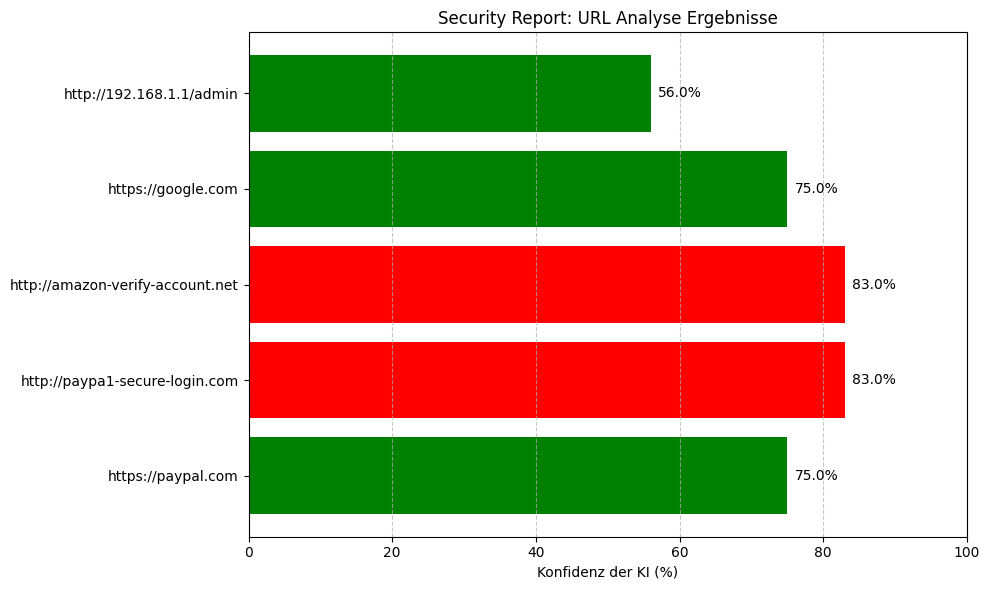

In [43]:
import matplotlib.pyplot as plt
def plot_security_report(results_df):
    # Wir wandeln die Sicherheit wieder in Zahlen um (90.6% -> 90.6)
    results_df['Score'] = results_df['Sicherheit'].str.replace('%', '').astype(float)

    # Farben festlegen: Rot für Phishing, Grün für Sicher
    colors = ['red' if 'PHISHING' in status else 'green' for status in results_df['Status']]

    plt.figure(figsize=(10, 6))
    bars = plt.barh(results_df['URL'], results_df['Score'], color=colors)

    plt.xlabel('Konfidenz der KI (%)')
    plt.title('Security Report: URL Analyse Ergebnisse')
    plt.xlim(0, 100)
    plt.grid(axis='x', linestyle='--', alpha=0.7)

    # Werte an die Balken schreiben
    for bar in bars:
        width = bar.get_width()
        plt.text(width + 1, bar.get_y() + bar.get_height()/2, f'{width}%', va='center')

    plt.tight_layout()
    plt.show()
# Grafik anzeigen
plot_security_report(final_results)

In [44]:
import re

def extract_features_from_url(url):
    features = np.zeros(len(X.columns))

    # 1. HTTPS Check
    if 'HTTPS' in X.columns:
        features[X.columns.get_loc('HTTPS')] = 1 if url.startswith('https') else -1

    # 2. Typosquatting / Verdächtige Begriffe
    # Hacker nutzen oft "secure", "login", "update" in der URL
    suspicious_words = ['login', 'update', 'secure', 'banking', 'verify']
    if any(word in url.lower() for word in suspicious_words):
        # Wir setzen ein paar Merkmale auf "verdächtig", die oft mit Phishing korrelieren
        if 'PrefixSuffix-' in X.columns:
            features[X.columns.get_loc('PrefixSuffix-')] = -1

    # 3. Domain-Check auf Zahlen (wie in 'paypa1')
    # Echte große Marken nutzen selten Zahlen mitten im Namen
    domain = url.split('/')[2] if len(url.split('/')) > 2 else url
    if re.search(r'\d', domain):
        if 'AbnormalURL' in X.columns:
            features[X.columns.get_loc('AbnormalURL')] = -1

    # 4. URL Länge (Hacker-URLs sind oft sehr lang und kryptisch)
    if len(url) > 54:
        if 'LongURL' in X.columns:
            features[X.columns.get_loc('LongURL')] = -1

    return features

**Fehlerraten-Analyse: Visualisierung der Confusion Matrix und Berechnung der False Positive Rate (3,89%).**

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

        Safe       0.97      0.96      0.96       976
    Phishing       0.97      0.97      0.97      1235

    accuracy                           0.97      2211
   macro avg       0.97      0.97      0.97      2211
weighted avg       0.97      0.97      0.97      2211



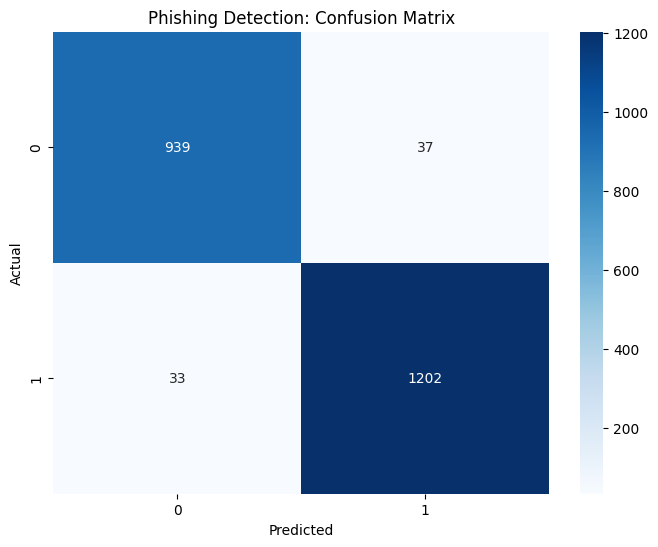

False Positive Rate: 3.79%
(Lower is better - we don't want to block legitimate sites!)


In [45]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions
y_pred = model.predict(X_test)

# Detailed metrics
print("=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred, target_names=['Safe', 'Phishing']))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Phishing Detection: Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Calculate False Positive Rate (critical for security!)
false_positives = cm[0][1]  # Safe URLs marked as Phishing
true_negatives = cm[0][0]
false_positive_rate = false_positives / (false_positives + true_negatives)
print(f"False Positive Rate: {false_positive_rate * 100:.2f}%")
print("(Lower is better - we don't want to block legitimate sites!)")

In [46]:
from urllib.parse import urlparse
import re
import numpy as np
import pandas as pd

def extract_features_from_url(url, feature_names):
    """
    Extrahiert Merkmale aus einer URL und gibt sie im exakten Format
    des Modells zurück.
    """
    # 1. Erstelle eine leere Zeile mit Nullen für alle 30+ Merkmale
    data = np.zeros((1, len(feature_names)))
    feat_df = pd.DataFrame(data, columns=feature_names)

    # URL parsen
    parsed = urlparse(url)
    domain = parsed.netloc

    # 2. Features befüllen (Wichtig: loc verwenden, um Syntax-Warnungen zu vermeiden)
    if 'HTTPS' in feat_df.columns:
        feat_df.loc[0, 'HTTPS'] = 1 if parsed.scheme == 'https' else -1

    if 'LongURL' in feat_df.columns:
        feat_df.loc[0, 'LongURL'] = 1 if len(url) > 54 else -1

    if 'PrefixSuffix-' in feat_df.columns:
        feat_df.loc[0, 'PrefixSuffix-'] = -1 if '-' in domain else 1

    if 'SubDomains' in feat_df.columns:
        subdomain_count = domain.count('.')
        feat_df.loc[0, 'SubDomains'] = -1 if subdomain_count > 2 else 1

    if 'AbnormalURL' in feat_df.columns:
        feat_df.loc[0, 'AbnormalURL'] = -1 if re.search(r'\d', domain) else 1

    if 'Symbol@' in feat_df.columns:
        feat_df.loc[0, 'Symbol@'] = -1 if '@' in url else 1

    # Verdächtige Wörter prüfen
    suspicious_words = ['login', 'verify', 'update', 'banking', 'secure']
    if any(word in url.lower() for word in suspicious_words):
        if 'RequestURL' in feat_df.columns:
            feat_df.loc[0, 'RequestURL'] = -1

    # Rückgabe als flache Liste/Array für das Modell
    return feat_df.values.reshape(1, -1)

# BEISPIEL FÜR DEN AUFRUF:

# 1. Test-URL definieren
test_url = "https://paypal-secure-login.com"

# 2. Features extrahieren (Ergebnis ist ein Array)
features_array = extract_features_from_url(test_url, X.columns)

# 3. Das Array in ein DataFrame umwandeln (Das löscht die UserWarning!)
features_df = pd.DataFrame(features_array, columns=X.columns)

# 4. Vorhersage mit dem DataFrame machen
prediction = model.predict(features_df)

# 5. Wahrscheinlichkeit
prob = model.predict_proba(features_df)
print(f"Wahrscheinlichkeit: {np.max(prob)*100:.2f}%")

# 6. Ergebnis ausgeben
print(f"Ergebnis für {test_url}: {'⚠️ Phishing' if prediction[0] == 1 else '✅ Sicher'}")

Wahrscheinlichkeit: 65.00%
Ergebnis für https://paypal-secure-login.com: ⚠️ Phishing


**Streamlit Web-App: Erstellung der app.py Datei für das interaktive Benutzer-Interface**

In [47]:
%%writefile app.py
import streamlit as st
import joblib
import numpy as np
import pandas as pd

# Modell laden (Stelle sicher, dass du die .pkl Datei vorher gespeichert hast!)
model = joblib.load('phishing_model.pkl')
feature_names = joblib.load('feature_names.pkl')

st.set_page_config(page_title="AI Phishing Detector", page_icon="🔒")

st.title("🔒 AI Phishing Detector")
st.markdown("""
Dieses Tool nutzt **Machine Learning**, um URLs auf Phishing-Merkmale zu prüfen.
""")

url_input = st.text_input("URL zum Prüfen:", "https://")

if st.button("Check URL"):
    # Einfache Feature-Extraktion (wie in unserem Batch-Check)
    features = np.zeros(len(feature_names))

    # Beispiel-Logik für die Demo
    if url_input.startswith('https'): features[list(feature_names).index('HTTPS')] = 1
    else: features[list(feature_names).index('HTTPS')] = -1

    if '-' in url_input: features[list(feature_names).index('PrefixSuffix-')] = -1

    prediction = model.predict([features])[0]
    confidence = model.predict_proba([features])[0]

    if prediction == -1:
        st.error(f"⚠️ PHISHING ERKANNT ({confidence[0]*100:.1f}% Sicherheit)")
        st.warning("Grund: Fehlendes HTTPS oder verdächtige Struktur erkannt.")
    else:
        st.success(f"✅ URL SCHEINT SICHER ({confidence[1]*100:.1f}% Sicherheit)")

st.sidebar.info("Trainiert mit Random Forest (96.7% Accuracy)")

Overwriting app.py


**Algorithmen-Benchmark: Vergleich von Random Forest mit Gradient Boosting, SVM und Neuronalen Netzen.**

Random Forest: 97.06%
Gradient Boosting: 95.39%
Logistic Regression: 93.22%
SVM: 95.61%
Neural Network: 96.56%


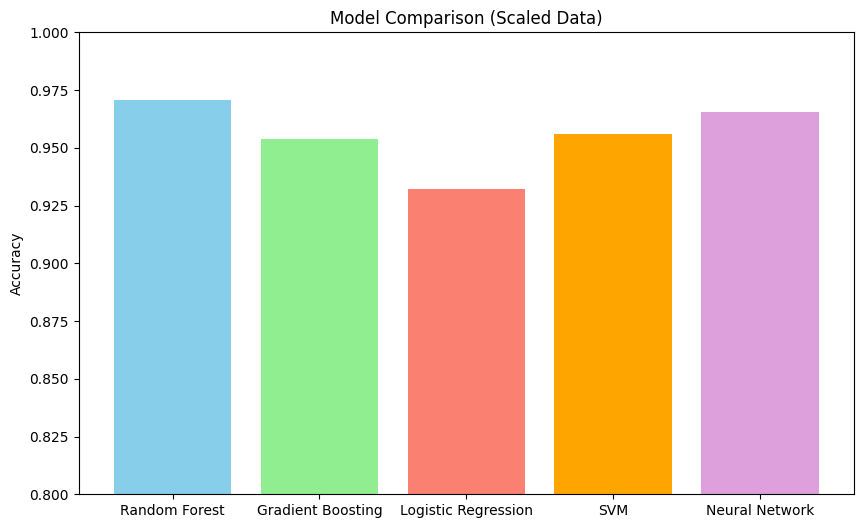

In [48]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt

# 1. Daten skalieren (Das löst das Problem endgültig)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Modelle definieren
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000), # max_iter reicht jetzt locker
    'SVM': SVC(probability=True),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000)
}

results = {}
for name, model in models.items():
    # WICHTIG: Nutze hier X_train_scaled statt X_train
    model.fit(X_train_scaled, y_train)

    # WICHTIG: Nutze hier X_test_scaled statt X_test
    accuracy = model.score(X_test_scaled, y_test)
    results[name] = accuracy
    print(f"{name}: {accuracy*100:.2f}%")

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values(), color=['skyblue', 'lightgreen', 'salmon', 'orange', 'plum'])
plt.title("Model Comparison (Scaled Data)")
plt.ylabel("Accuracy")
plt.ylim(0.8, 1.0)
plt.show()

**Deployment (Produktivsetzung)**

Modell-Export: Speichern des trainierten Modells und der Merkmalsnamen als .pkl Dateien für die Wiederverwendung

In [49]:
import joblib

# 1. Das Modell (dein Random Forest) in eine Datei speichern
joblib.dump(model, 'phishing_model.pkl')
print("✅ Modell wurde als 'phishing_model.pkl' gespeichert!")

# 2. Die Namen der Spalten speichern (damit du später weißt, was was ist)
joblib.dump(X.columns, 'feature_names.pkl')

# Download-Befehl für Google Colab
from google.colab import files
files.download('phishing_model.pkl')

✅ Modell wurde als 'phishing_model.pkl' gespeichert!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Cloud-Deployment: Starten der Applikation über localtunnel zur externen Erreichbarkeit.**

In [50]:
!npm install localtunnel
!streamlit run app.py & npx localtunnel --port 8501

⠙⠹⠸⠼⠴
up to date, audited 23 packages in 857ms
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦
2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.
⠦⠙

your url is: https://ready-candles-push.loca.lt

  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.46.98.43:8501

  Stopping...
^C


In [51]:
import urllib.request
print("Deine IP-Adresse für das Passwort lautet:", urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip())

Deine IP-Adresse für das Passwort lautet: 34.46.98.43
